# Extraction of electrical features (eFeatures) from experimental data

___

Authors of this script:

Elisabetta Iavarone @ Blue Brain Project

Experimental data: Rodrigo Perin @ LNMC, EPFL



____



## Overview

____

In this tutorial we will see how to extract electrical features (eFeatures), such as spike amplitude, firing frequency, etc... from experimental traces. The eFeatures describe the electrical behavior of a neuron recorded experimentally and can be used to constrain the parameters of neuron models.

![Segments](eFeatures.png "Title")

[Here](http://efel.readthedocs.io/en/latest/eFeatures.html) you can see further description of eFeatures.

The steps we will follow are:

1) Visualize the data of a Neocortical Layer 5 Tufted Pyramidal neuron (data courtesy of Rodrigo Perin @ LNMC, EPFL). Similar data can be downloaded from  the [Neocortical Microcircuit Collaboration Portal](http://microcircuits.epfl.ch/#/article/article_4_eph).

2) Electrophysiological features will be extracted from the voltage traces, thanks to the ** Electrophys Feature Extraction Library ** [eFEL](https://github.com/BlueBrain/eFEL).

3) We will use experimental current traces to create stimulation protocols that we will use to simulate the neuron model.

In the next tutorial we will use the **Blue Brain Python Optimisation Library** [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to create a model template for the [NEURON simulator](https://www.neuron.yale.edu/neuron/). There you'll see how to combine the eFeatures and protocols to setup an optimization of a neuron model.

We first import some useful Python modules.

In [7]:
%load_ext autoreload
%autoreload

import numpy, IPython
import json, os

import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = 6, 6

import collections

from json2html import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Electrophysiology data - voltage responses
In this section we will process the electrophysiological data recorded with patch-clamp (current-clamp) experiments.

For this example we have chosen to use one negative current step and two positive current steps with different durations. 

We store the data in a Python dictionary.

In [8]:
import os

# Define the directory containing the traces
data_dir = 'data/'
os.listdir(data_dir)

['exp_IDRest_ch20_3110.dat',
 'exp_IDRest_ch20_2113.dat',
 'exp_IV_ch21_4030.dat',
 'exp_IV_ch20_3026.dat',
 'exp_IDRest_ch21_4114.dat',
 'exp_IV_ch21_2029.dat',
 'exp_APWaveform_ch21_4036.dat',
 'exp_APWaveform_ch20_4036.dat',
 'exp_IDRest_ch21_3110.dat',
 'exp_IV_ch20_4030.dat',
 'exp_APWaveform_ch21_2035.dat',
 'exp_APWaveform_ch21_3032.dat',
 'exp_APWaveform_ch20_3032.dat',
 'exp_IDRest_ch21_2113.dat',
 'exp_IV_ch21_3026.dat',
 'exp_APWaveform_ch20_2035.dat',
 'exp_IDRest_ch20_4114.dat',
 'exp_IV_ch20_2029.dat']

___
### Traces description

* All the recordings you see above represent different **stimuli** (e.g. "APWaveform", "IDRest", "IV"). 
* Each stimulus is repeated multiple times (e.g. *APWaveform...2035, 3032, 4036*). In the example above we have three **repetitions** of each stimulus.
* Any individual recording has a **trace number** (e.g. *_2035*). Note that we have pairs of recordings with the same trace number (e.g. "exp_APWaveform_ch21_2035.dat" and "exp_APWaveform_ch20_2035.dat") but different channels (*ch*). One of them contains the current stimulus (in this case *ch21*) and the other the voltage response (in this case *ch20*).
___

With the code below we can for example select traces based on stimulus name and store them in Python dictionaries.

In [9]:
# Store voltage data in a dictionary step_name : [list of repetitions]
steps_v_dict = collections.OrderedDict({'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []})

# Store current data in a dictionary step_name : [list of repetitions]
steps_i_dict = collections.OrderedDict({'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []})

# Import the glob Python module to interact with the data directory
import glob

files_list = glob.glob1(data_dir, "*.dat")

for file_name in files_list:
    # Get channel and trace number from the file_name
    channel = int(file_name[:-4].split('_')[2][2:])
    tracenum = int(file_name[:-4].split('_')[-1])
    
    # Even channel numbers are voltage traces in this case
    if channel % 2 == 0:
        if "APWaveform" in file_name:
            steps_v_dict['ShortStepPos'].append(numpy.fromfile(os.path.join(data_dir,file_name)))
        if "IDRest" in file_name:
            steps_v_dict['LongStepPos'].append(numpy.fromfile(os.path.join(data_dir,file_name)))
        if "IV" in file_name:
            steps_v_dict['LongStepNeg'].append(numpy.fromfile(os.path.join(data_dir,file_name)))
            
    # Odd channel numbers are current traces in this case        
    elif channel % 2 == 1:
        if "APWaveform" in file_name:
            steps_i_dict['ShortStepPos'].append(numpy.fromfile(os.path.join(data_dir,file_name)))
        if "IDRest" in file_name:
            steps_i_dict['LongStepPos'].append(numpy.fromfile(os.path.join(data_dir,file_name)))
        if "IV" in file_name:
            steps_i_dict['LongStepNeg'].append(numpy.fromfile(os.path.join(data_dir,file_name)))

print("Created steps_v_dict.\nIt containes {} stimuli, {} repetitions for each stimulus.".format(len(steps_v_dict),
                                                                                      len(steps_v_dict["ShortStepPos"])))            

Created steps_v_dict.
It containes 3 stimuli, 3 repetitions for each stimulus.


We can now plot these traces.

<IPython.core.display.Javascript object>


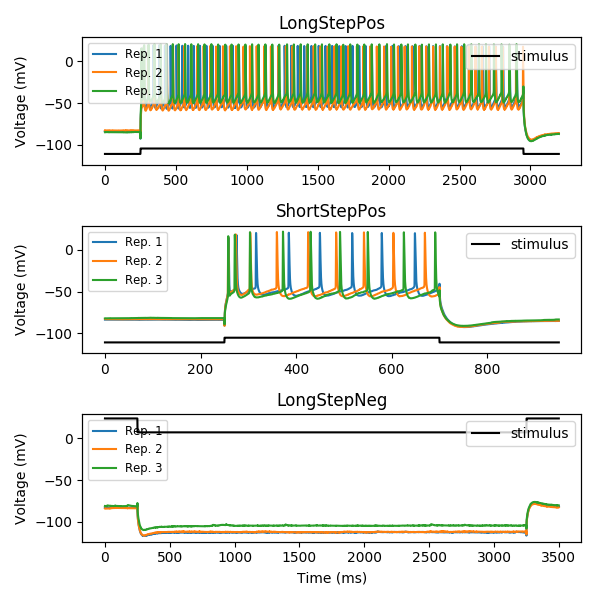

In [10]:
# Initialize a figure
fig1, axes = plt.subplots(len(steps_v_dict), sharey = True)

# Plot the voltage traces
for idx, step_name in enumerate(steps_v_dict.keys()):
    for rep, trace in enumerate(steps_v_dict[step_name]):
        data = trace.reshape(len(trace)/2,2)
        axes[idx].plot(data[:,0],data[:,1], label = 'Rep. ' + str(rep+1))
        axes[idx].set_ylabel('Voltage (mV)')
        axes[idx].legend(loc = 2, fontsize = 'small')
        axes[idx].set_title(step_name)
    axes[-1].set_xlabel('Time (ms)')
    
for idx, step_name in enumerate(steps_i_dict.keys()):
    trace = steps_i_dict[step_name][0]
    data = trace.reshape(len(trace)/2,2)
    #ax2 = fig.add_axes([0.72, 0.72, 0.16, 0.16])
    ax2 = axes[idx].twinx()
    ax2.plot(data[:,0],data[:,1], color = 'black', label = "stimulus")
  
    ax2.set_ylim([-2, 20]) if "Pos" in step_name else ax2.set_ylim([-4, 0])
    ax2.legend(loc=1)    
    ax2.set_yticks([])    
    
plt.tight_layout()

# 2. Electrophysiological features
To build a detailed neuron model, we need to quantify the electrical behavior we want to reproduce. The metrics we use are the eFeatures, that measure parameters describing for instance the shape of the action potential or the firing properties of a neuron (see [here](http://bluebrain.github.io/eFEL/eFeatures.html) for eFeatures description).

In this example, we extract distinct features from the three types of voltage traces above.
The eFeatures extracted from the data and later from the model will be used to evaluate the performance of the model.

The function below construct the traces format for the eFEL library.

In [24]:
# Extract features
import efel

# Define stimulus start and end times
steps_info = {'LongStepNeg': [250, 3250], 'ShortStepPos': [250, 700], 'LongStepPos': [250, 2950]}

# Prepare the traces for eFEL
def get_features(data):
    # All the traces converted in eFEL format
    efel_traces = {'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []}
    for step_name, step_traces in data.items():
        for rep in step_traces:            
            data = rep.reshape(len(rep)/2,2)
            # A single eFEL trace 
            trace = {}
            trace['T'] = data[:,0]
            trace['V'] = data[:,1] 
            trace['stim_start'] = [steps_info[step_name][0]]
            trace['stim_end'] = [steps_info[step_name][1]]
            trace['name'] = step_name
            
            efel_traces[step_name].append(trace)
    
    features_values = collections.defaultdict(dict)       
    
    features_values['LongStepNeg'] = efel.getMeanFeatureValues(efel_traces['LongStepNeg'], 
                                                                ['voltage_deflection',
                                                                'voltage_base'])

    features_values['LongStepPos'] = efel.getMeanFeatureValues(efel_traces['LongStepPos'], 
                                                               ['mean_frequency', 'adaptation_index2', 
                                                                'ISI_CV'])
    
    features_values['ShortStepPos'] = efel.getMeanFeatureValues(efel_traces['ShortStepPos'], 
                                                                ['time_to_first_spike', 'AHP_depth', 
                                                                'AP_width', 'AP_height'])
    
    # Round raw feature values
    for stim_name in efel_traces.keys():
        for idx, stim in enumerate(features_values[stim_name]):
            for feat_name in features_values[stim_name][idx].keys():
                features_values[stim_name][idx][feat_name] = round(features_values[stim_name][idx][feat_name], 4)        

    return features_values

To extract the features from the *step_v_dict* dictionary we just need to pass them as argument to the function above.

We can now visualise the feature values we computed, each row in the table corresponds to a repetition of the same step.

In [25]:
efel_features = dict(get_features(steps_v_dict))
IPython.display.HTML(json2html.convert(json=efel_features))

We compute features mean and standard deviation and save them in a [.json file](https://en.wikipedia.org/wiki/JSON#Example) for later use. Python dictionary and lists can be easily written and read from .json files.

In [26]:
features_dict = collections.OrderedDict()
for step_name, reps in efel_features.items():
    feature_values = collections.defaultdict(list)
    for rep in reps: 
        for feature_name, value in rep.iteritems():
            feature_values[feature_name].append(value)
   
    features_dict[step_name] = {}
    for name, values in feature_values.items():
        features_dict[step_name][name] = {"std":round(numpy.std(values), 4),
                                                  "mean":round(numpy.mean(values), 4)}

# Save to json
with open("features.json", "w") as f:
    json.dump(features_dict, f, indent = 4)
    
IPython.display.HTML(json2html.convert(json=dict(features_dict)))

## 3. Analyse the stimulation protocols

Now it's time to process the current stimuli that were used to record the voltage responses seen above.

<IPython.core.display.Javascript object>


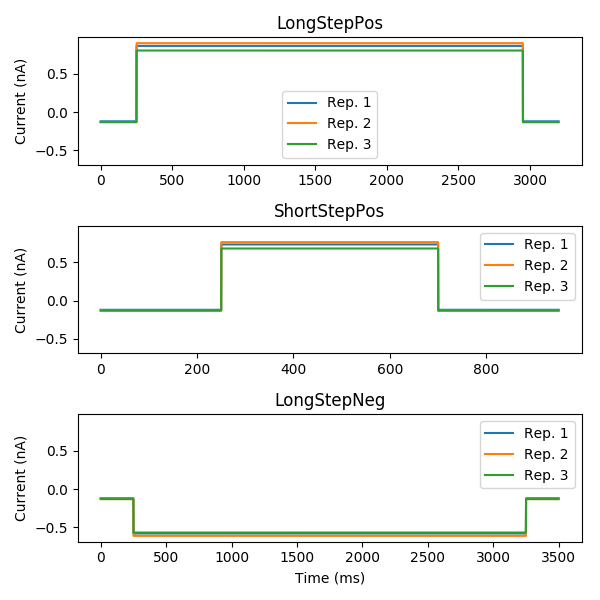

In [82]:
# Plot the current traces
# Initialize a figure
fig1, axes = plt.subplots(len(steps_i_dict), sharey = True)

for idx, step_name in enumerate(steps_i_dict.keys()):
    for rep, trace in enumerate(steps_i_dict[step_name]):
        data = trace.reshape(len(trace)/2,2)
        axes[idx].plot(data[:,0],data[:,1], label = 'Rep. ' + str(rep+1))
        axes[idx].set_ylabel('Current (nA)')
        axes[idx].legend(loc = 'best')
        axes[idx].set_title(step_name)
    axes[-1].set_xlabel('Time (ms)')
plt.tight_layout()

If we look at the traces above, we can notice that the current steps are composed by a **holding current** (from 0 ms to the end of the stimulus) and a **step current** (from 250 ms to 250 ms from the end of the stimulus).

Now we are going to create a dictionary with all the information on the stimulation protocol (start and end time of the stimuli and their amplitude).

In [9]:
protocols_dict = collections.OrderedDict()

# Stimuli start and end time
steps_info = {'LongStepNeg': [250, 3250], 'ShortStepPos': [250, 700], 'LongStepPos': [250, 2950]}

# Stimuli holding current and step current amplitudes in nA
amps_info = collections.defaultdict(list)
for step_name in steps_i_dict.keys():
    
    iholds = []
    isteps = []
    for trace in steps_i_dict[step_name]:
        data = trace.reshape(len(trace)/2,2)
        tot_duration = steps_info[step_name][1]+steps_info[step_name][0]
   
        dt = float(tot_duration)/len(data)
        ihold = numpy.mean(data[:,1][0:int(steps_info[step_name][0]/dt)])

        istep = numpy.mean(data[:,1][int(steps_info[step_name][0]/dt):int(steps_info[step_name][1]/dt)])-ihold
        iholds.append(ihold)
        isteps.append(istep)
       
    amps_info[step_name].append(round(numpy.mean(isteps), 4))
    amps_info[step_name].append(round(numpy.mean(iholds), 4)) 
    
#amps_info  = {'LongStepNeg': [-0.01, 0.05], 'ShortStepPos': [0.18,0.05],'LongStepPos': [0.15 ,0.05]}

for step_name, reps in efel_features.items():   
    protocols_dict[step_name] = {"stimuli":[]}
    protocols_dict[step_name]["stimuli"].append({"delay":steps_info[step_name][0],
                                               "amp":amps_info[step_name][0],
                                               "duration":steps_info[step_name][1]-steps_info[step_name][0],
                                               "totduration":steps_info[step_name][1]+steps_info[step_name][0]})
    protocols_dict[step_name]["stimuli"].append({"delay":0,
                                               "amp":amps_info[step_name][1],
                                               "duration":steps_info[step_name][1]+steps_info[step_name][0],
                                               "totduration":steps_info[step_name][1]+steps_info[step_name][0]})
    
IPython.display.HTML(json2html.convert(json=dict(protocols_dict)))


Now we have all the eFeatures and stimulation protocols to constrain neuron models with electrophysiology data.

### Exercise - Visualise some spike eFeatures 

Complete the code below in order to extract:

1. Action potentials **(AP) peak times**, 

2. Action potentials **(AP) height** (maximum overshoot voltage)

3. **Minimum voltage between the spikes**

from "LongStepPos" traces and plot them.

The result should be similar to the last figures in this [eFEL example](https://github.com/BlueBrain/eFEL/blob/master/examples/nmc-portal/L5TTPC2.ipynb).

In [85]:
# TODO: retrieve the LongStepPos traces from the steps_v_dict dictionary
traces_data = __

In [88]:
# Just run this cell
traces_efel = []

for data in traces_data:
    trace = {}
    trace['T'] = data.reshape(len(data)/2, 2)[:,0]
    trace['V'] = data.reshape(len(data)/2, 2)[:,1]
    trace['stim_start'] = [steps_info['LongStepPos'][0]]
    trace['stim_end'] = [steps_info['LongStepPos'][1]]
    
    traces_efel.append(trace)
    
print("We are going to analyse {} traces.".format(len(traces_efel)))    

We are going to analyse 0 traces.


In [87]:
# TODO: use the efel "getFeatureNames" function to find the names
# for the peak times, action potential height and the the AHP absolute depth

print ""

In [ ]:
# TODO: replace "__" with the three feature names
efeatures = efel.getFeatureValues(traces_efel, ["__", "__", "__"]) 

In [ ]:
fig1, axes = plt.subplots(len(traces_data))

# These are "list comprehensions", a more compat way for writing for loops in Python
[axes[idx].plot(traces_efel[rep]['T'], traces_efel[idx]['V']) for idx, trace in enumerate(traces_data)]

# Plot spike times (x axis) and spike hights (y axis)
[axes[idx].plot(efeatures[idx]["peak_time"], efeatures[idx]["AP_height"], "o") for idx, trace in enumerate(traces_data)]


In [ ]:
#TODO:
# Take inspiration from the line above to plot spike times (x axis) and AHP depths (y axis)
[____]